Matej Buršík

In [ ]:
# Import
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta

In [25]:
# Load and short information about the columns
df = pd.read_parquet('../data/london_terraced_forecasting.parquet', engine='pyarrow')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332363 entries, 0 to 332362
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date_of_transfer  332363 non-null  datetime64[ns]
 1   price             332363 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.1 MB


,date_of_transfer,price
0,1995-01-01,85000
1,1995-01-01,117000
2,1995-01-02,254000
3,1995-01-02,44000
4,1995-01-03,47000


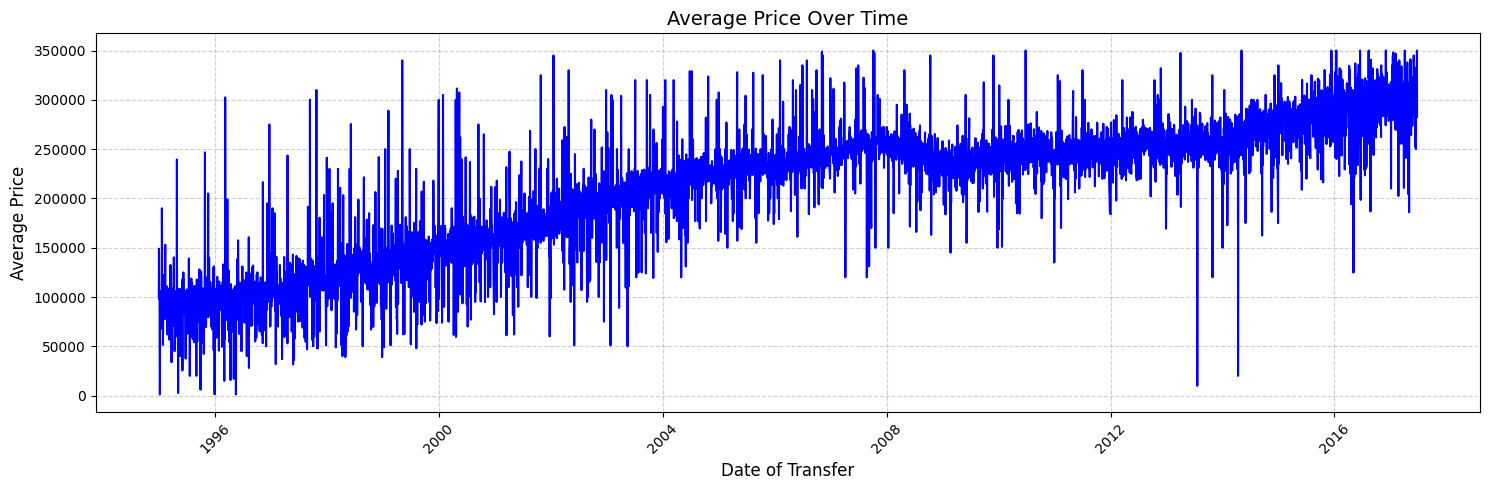

In [26]:
# Group by date and calculate average price for a cleaner line graph
avg_price_per_day = df.groupby('date_of_transfer')['price'].mean()

# Plot
plt.figure(figsize=(15, 5))
plt.plot(avg_price_per_day.index, avg_price_per_day.values, linestyle='-', color='b')
plt.title("Average Price Over Time", fontsize=14)
plt.xlabel("Date of Transfer", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Prophet requires a dataframe with columns 'ds' (date) and 'y' (value)
df = df.rename(columns={'date_of_transfer': 'ds', 'price': 'y'})
df.head()

,ds,y
0,1995-01-01,85000
1,1995-01-01,117000
2,1995-01-02,254000
3,1995-01-02,44000
4,1995-01-03,47000


In [29]:
# Get the most recent date
most_recent_date = df['ds'].max()

# Calculate the cutoff date for the last 300 days
cutoff_date = most_recent_date - timedelta(days=300)

# Extract rows from the last 300 days
df_last_300 = df[df['ds'] > cutoff_date]

# Create a DataFrame excluding the last 300 days
df_excluding_last_300 = df[df['ds'] <= cutoff_date]

In [30]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_excluding_last_300)

20:05:28 - cmdstanpy - INFO - Chain [1] start processing
20:07:14 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Make a DataFrame for future dates
future = model.make_future_dataframe(periods=300)
# Predict future values
forecast = model.predict(future)

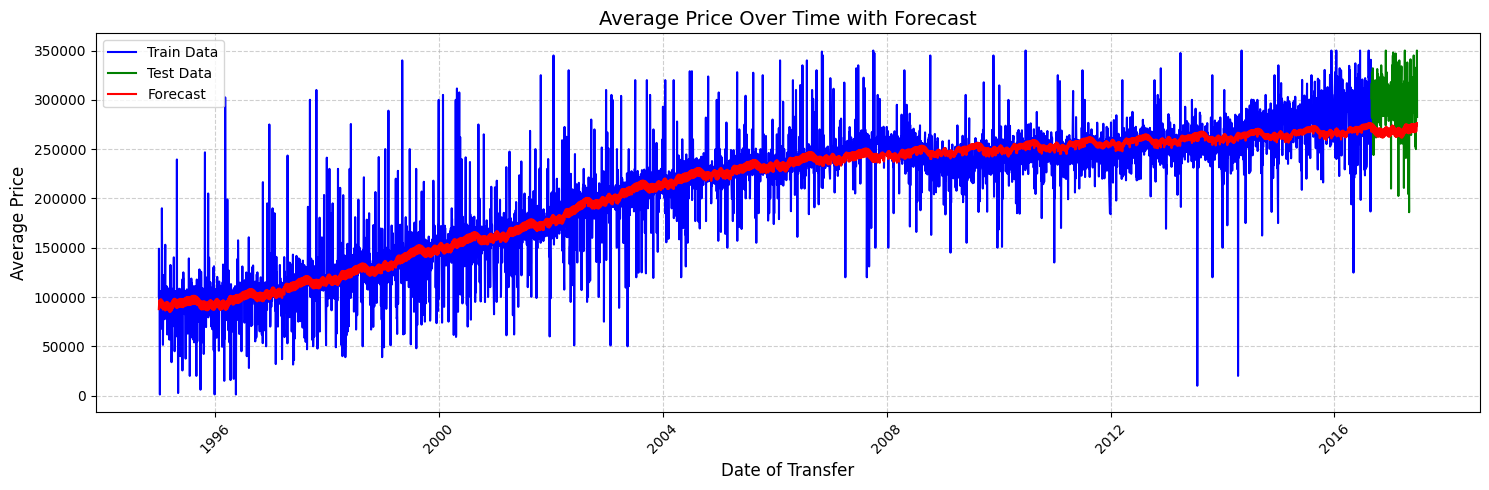

In [33]:
# Group by date and calculate average price for a cleaner line graph
avg_price_ex_300 = df_excluding_last_300.groupby('ds')['y'].mean()
avg_price_last_300 = df_last_300.groupby('ds')['y'].mean()

# Plot the original data and forecast together
plt.figure(figsize=(15, 5))

# Original data excluding last 300
plt.plot(avg_price_ex_300.index, avg_price_ex_300.values, linestyle='-', color='b', label="Train Data")

# Original data last 300
plt.plot(avg_price_last_300.index, avg_price_last_300.values, linestyle='-', color='g', label="Test Data")

# Forecasted values
plt.plot(forecast['ds'], forecast['yhat'], linestyle='-', color='r', label="Forecast")

# Adding details to the plot
plt.title("Average Price Over Time with Forecast", fontsize=14)
plt.xlabel("Date of Transfer", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
# Save the model
with open('forecast_prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)